In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')          # задаём красивый стиль для графиков matplotlib-а
%matplotlib inline

In [4]:
from tqdm import tqdm_notebook

In [5]:
# Gensim
import gensim
import gensim.corpora as corpora

In [6]:
data = pd.read_csv('reduced_comments_vk-24375-29c9bb.csv')

In [7]:
data.shape

(105377, 16)

### Из-за ограничений на доступные нам вычислительные ресурсы делаем выборку $80\%$ строк исходного датасета. 

In [8]:
data = data.sample(frac=0.8, replace=False, axis=0, random_state=42)

In [9]:
data.reset_index(drop=True, inplace=True)

In [10]:
data.shape

(84302, 16)

In [11]:
data.head()

Unnamed: 0 audio     author              comment_id                 date  \
0     2064647   NaN   37009931     51888_191073_191135  2012-09-13 07:04:16   
1      593478   NaN  293551612  23482802_486512_499462  2017-03-01 17:07:26   
2     2251350   NaN  141534370         325_83190_83442  2015-11-09 06:25:14   
3      116130   NaN  226980754     4336146_85407_85550  2017-09-12 14:21:45   
4     3112806   NaN   36200018        8509_57273_57275  2018-09-18 15:00:30   

                                          dirty_text emoji  likes  \
0  вы немного неправы. этот стих написал ребенок-...   NaN      0   
1  Ты хочешь жить не зная признаков души\nТы хоче...   NaN      0   
2  Не выдержал ))))) Народ че вы ноете? Нормальны...   NaN      2   
3  [id41348826|Влада], я говорю,не переводя стрел...   NaN      0   
4  Трио, лишённое не только гармонического инстру...   NaN      0   

                                                link music_style  performer  \
0                                                NaN       metal       ария   
1                                                NaN       popsa       крид   
2                                                NaN       metal   эпидемия   
3                                                NaN     estrada    меладзе   
4  môme швейцария дата стоимость мероприятие база...        jazz  jazz_джаз   

   stickers                                               text video  \
0       NaN  немного неправый стихнуть написать ребёнок инд...   NaN   
1       NaN  хотеть жить знать признак душа хотеть спать дь...   NaN   
2       NaN  выдержать народ ныть нормальный клип видеть сю...   NaN   
3       NaN  id41348826 влад говорить переводить стрелка го...   NaN   
4       NaN  трио лишить гармонический инструмент бас это с...   NaN   

                                            text_bow  comment_len  
0  ['немного', 'неправый', 'стихнуть', 'написать'...         71.0  
1  ['хотеть', 'жить', 'знать', 'признак', 'душа',...         64.0  
2  ['выдержать', 'народ', 'ныть', 'нормальный', '...         42.0  
3  ['id41348826', 'влад', 'говорить', 'переводить...         71.0  
4  ['трио', 'лишить', 'гармонический', 'инструмен...        166.0

### Загружаем "мешок слов"

In [10]:
from ast import literal_eval

In [11]:
bag_of_words = data.text_bow.apply(literal_eval)

### Добавляем биграммы к имеющемуся bag-of-words-представлению

In [12]:
bigrams = gensim.models.phrases.Phrases(bag_of_words)

In [14]:
data_words_bigrams = [bigrams[w] for w in tqdm_notebook(bag_of_words)]

### Составляем gensim-словарь терминов

In [15]:
id2word = corpora.Dictionary(data_words_bigrams)

### Убираем слишком редкие и слишком частые термины

In [16]:
id2word.filter_extremes(no_below=3, no_above=0.4, keep_n=3*10**6)

### Составляем итоговый корпус документов

In [17]:
corpus = [id2word.doc2bow(text) for text in tqdm_notebook(data_words_bigrams)]

In [18]:
with open('corpus', 'wb') as f:
    pickle.dump(corpus, f)

### Строим LDA-модель c 25 топиками

In [19]:
lda_model = gensim.models.ldamodel.LdaModel(
    corpus = corpus, 
    id2word = id2word,
    eval_every=20,
    num_topics=25,
    passes=5
    )

In [20]:
lda_model.save("ldamodel")

In [21]:
with open('expElogbeta.npy', 'wb') as f:
    np.save(f, lda_model.expElogbeta)

### Для каждого топика берем 100 наиболее популярных слов

In [23]:
topics = lda_model.show_topics(
    num_topics=25,
    num_words=100,
    formatted=False
    )

In [24]:
with open('topics', 'wb') as f:
    pickle.dump(topics, f)

## Визуализируем топики, построенных по всему корпусу текста

In [12]:
with open('ldamodel', 'rb') as f:
    model = pickle.load(f)

In [13]:
with open('corpus', 'rb') as f:
    corpus = pickle.load(f)

In [14]:
expElogbeta = np.load("expElogbeta.npy")
model.expElogbeta = expElogbeta

In [15]:
with open('topics', 'rb') as f:
    topics = pickle.load(f)

In [16]:
from wordcloud import WordCloud  # Пакет для построения облаков слов

In [17]:
def plotWordCloud(topics, topic_number):
    """
        Строит визуализацию слов на основе текстов топиков
    """
    # получаем частоты и слова топика
    
    text = dict(topics[topic_number][1])
    
    # строим облако слов
    wordcloud = WordCloud(background_color="white", max_words=100, width=900, height=900, collocations=False)
    wordcloud = wordcloud.generate_from_frequencies(text)
    plt.figure(figsize=(15, 10))
    plt.title("Топик номер {}".format(topic_number))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off");

In [18]:
 num_topics = model.num_topics

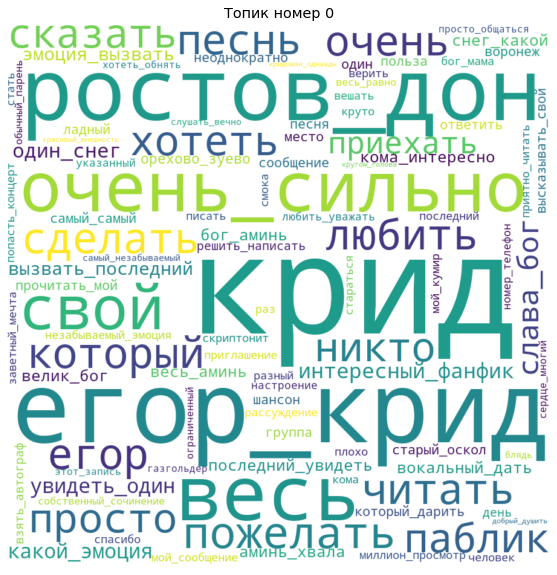

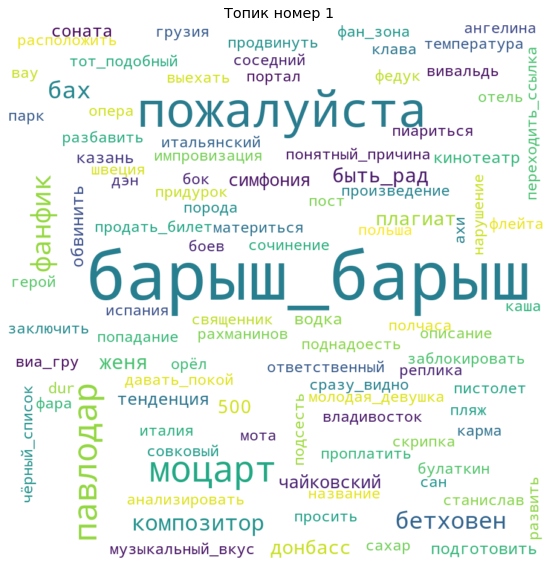

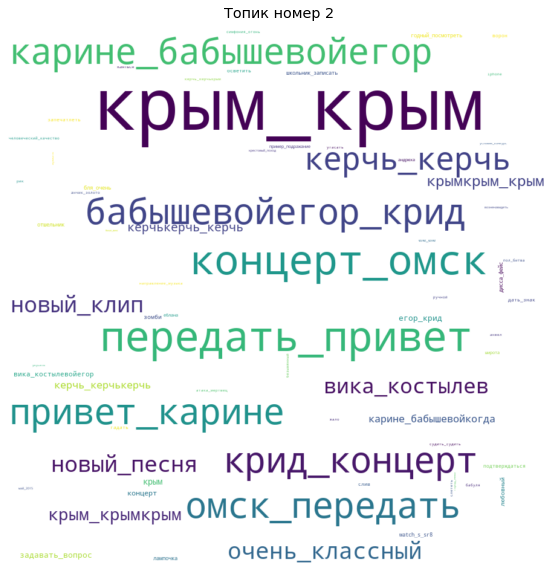

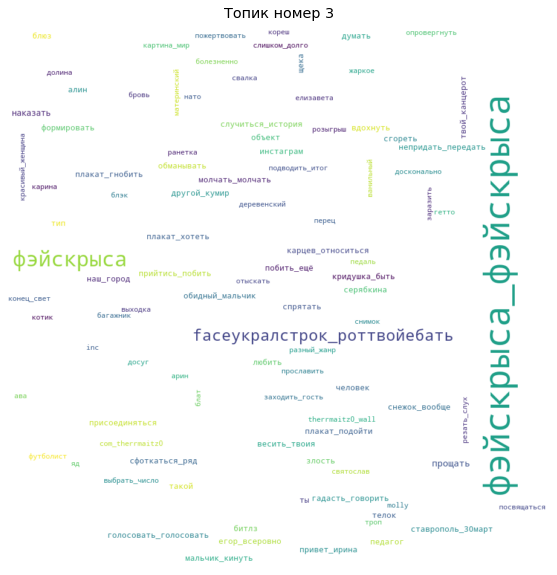

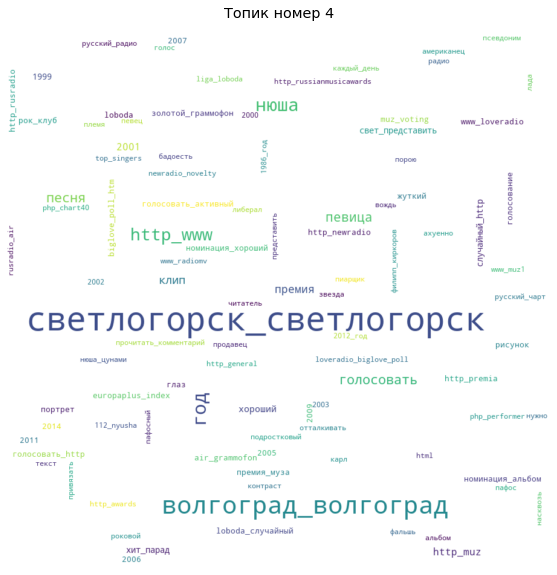

In [19]:
for i in range(0,5):
    plotWordCloud(topics, i)

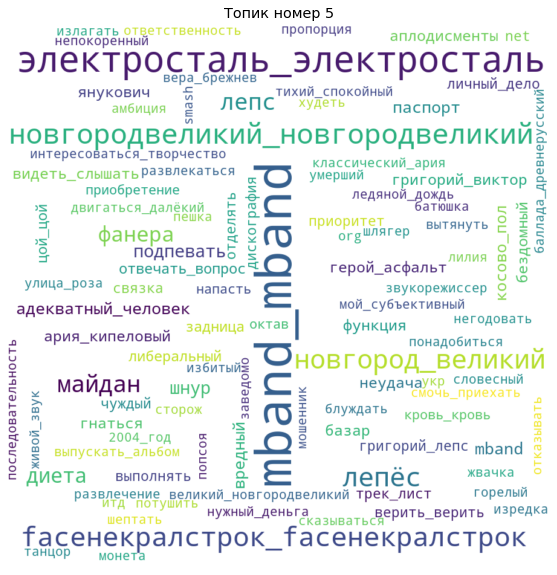

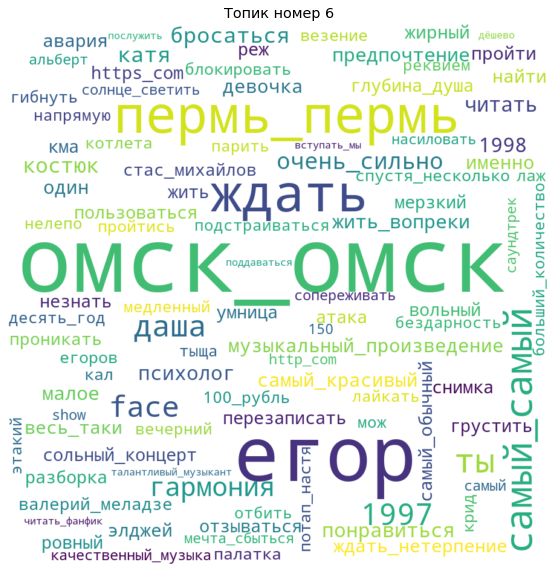

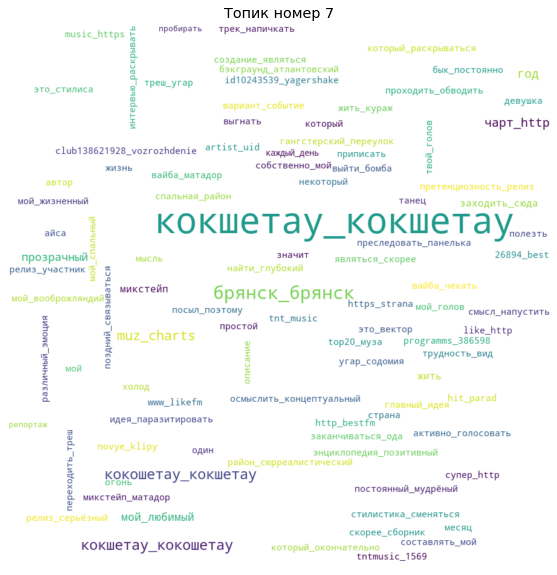

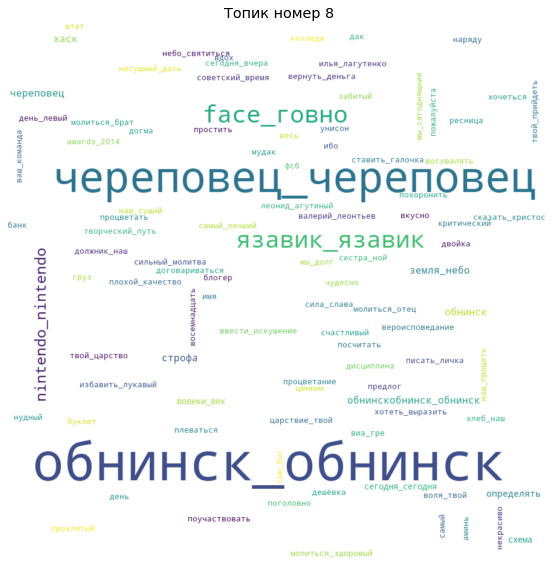

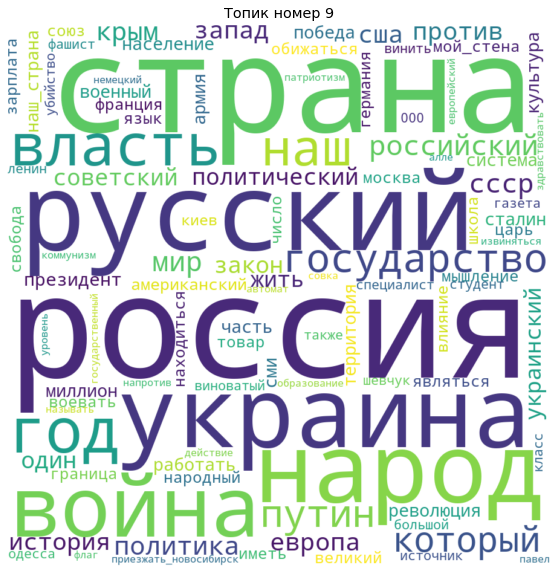

In [20]:
for i in range(5,10):
    plotWordCloud(topics, i)

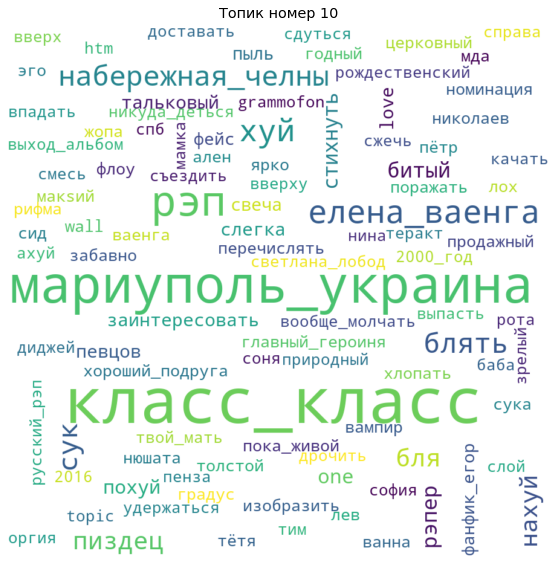

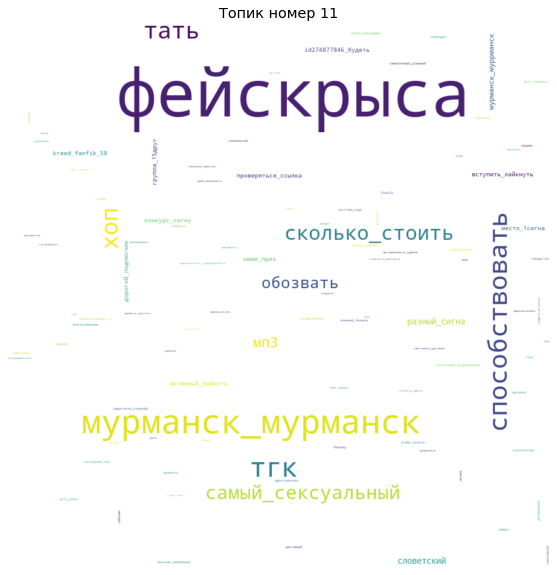

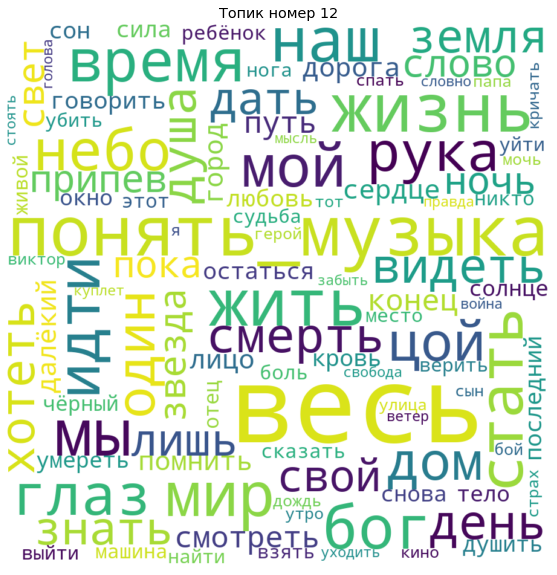

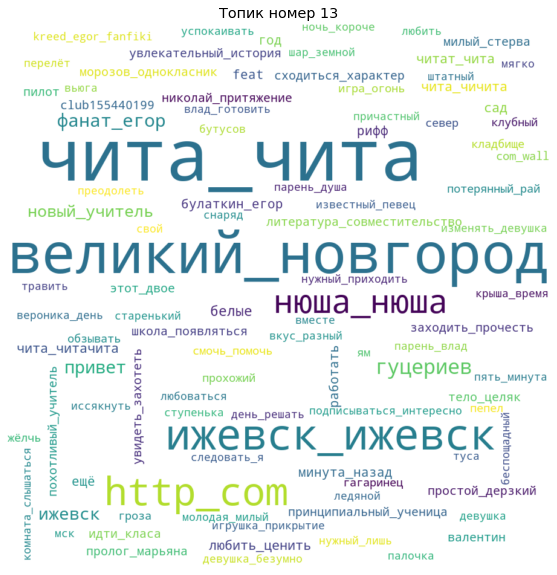

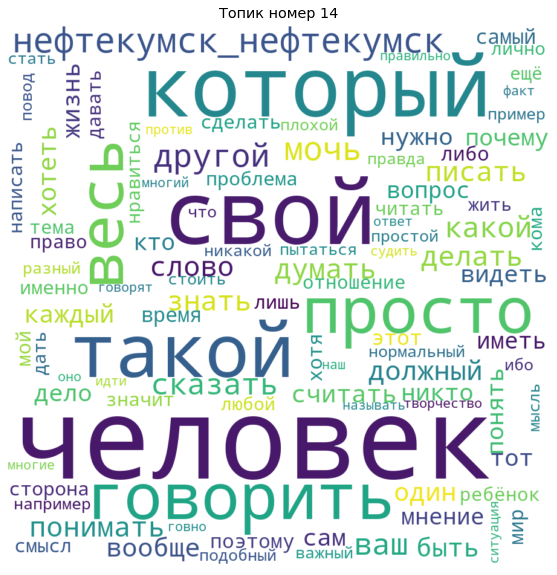

In [21]:
for i in range(10,15):
    plotWordCloud(topics, i)

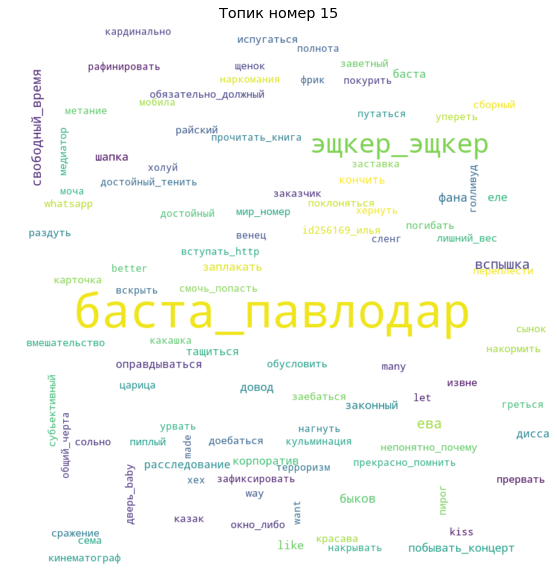

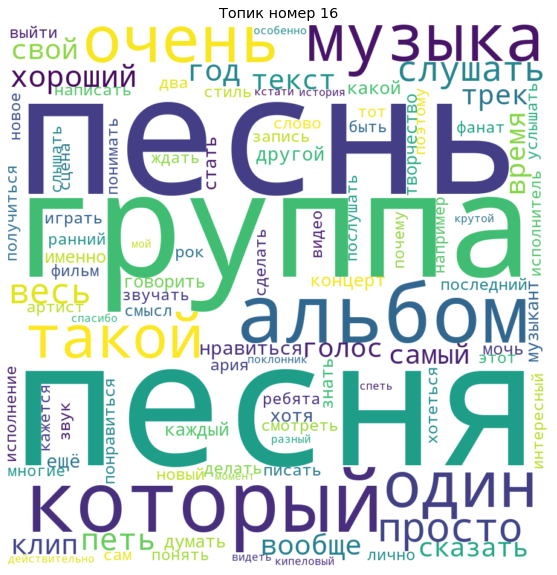

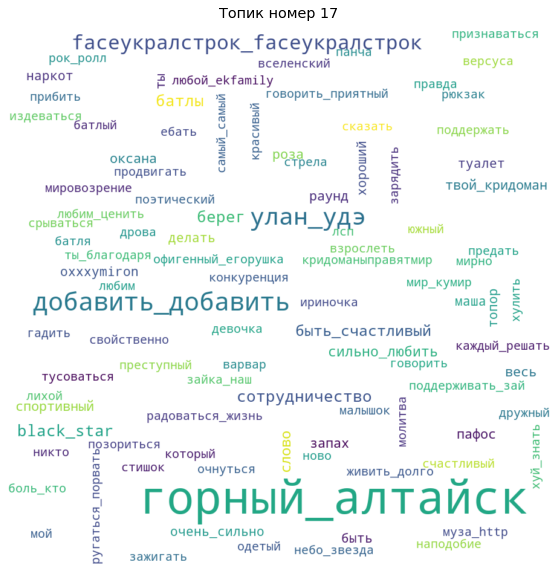

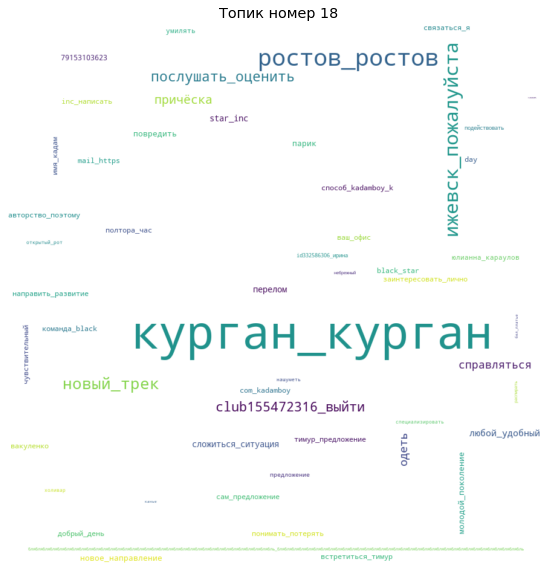

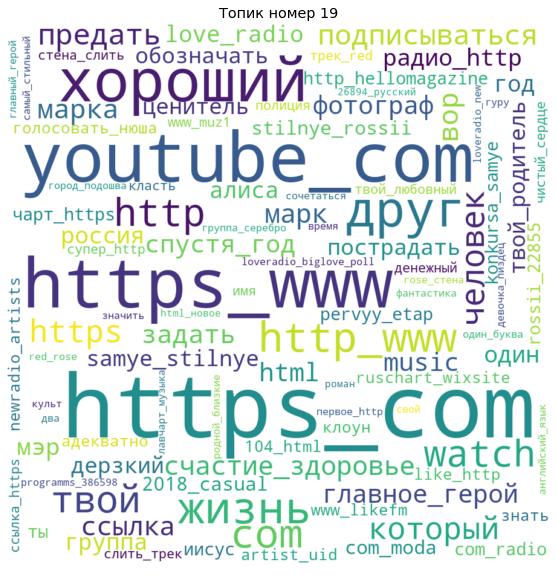

In [22]:
for i in range(15,20):
    plotWordCloud(topics, i)

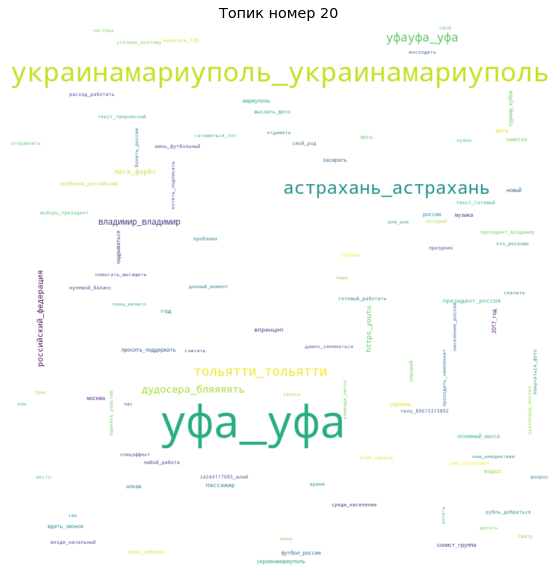

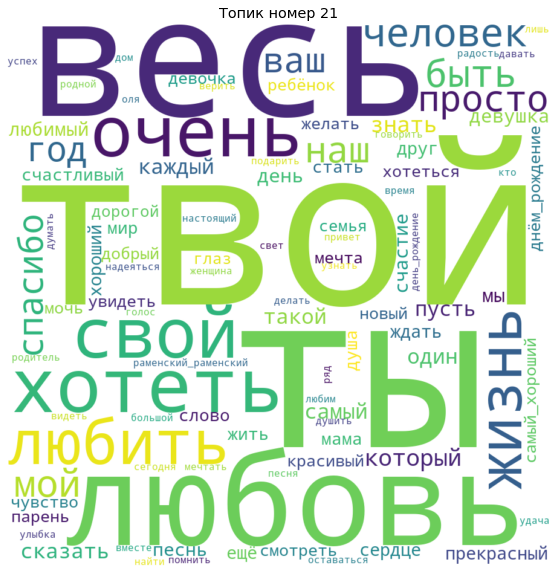

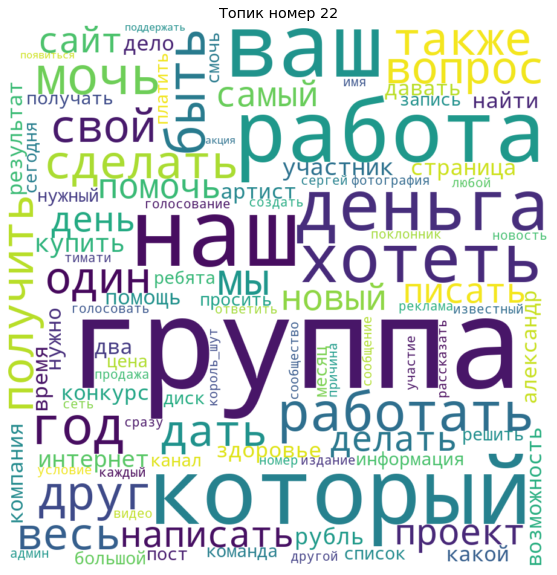

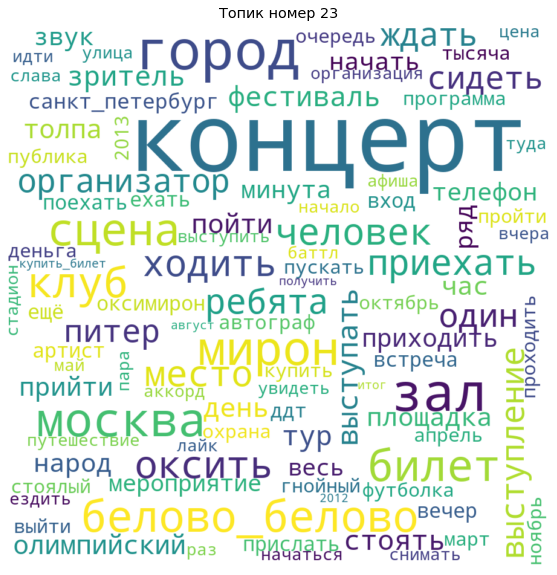

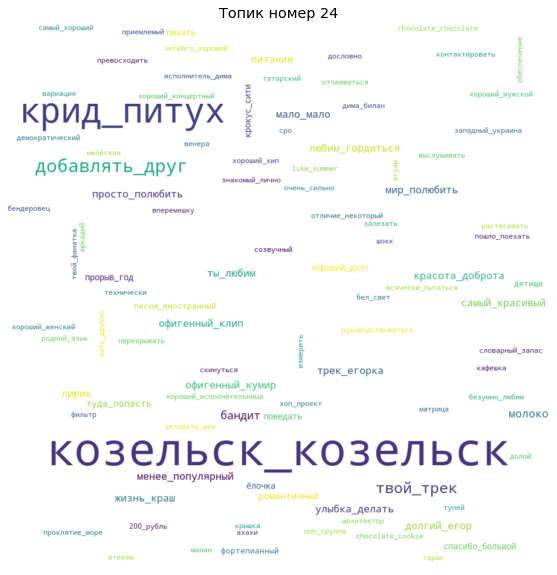

In [23]:
for i in range(20,25):
    plotWordCloud(topics, i)

### Придумываем интерпретацию для каждого из 25 топиков

In [30]:
themes_25 = {
     0 : 'егор крид',                  1 : 'концерты классической музыки', 
     2 : 'неинтерпретируемая',         3 : 'скандалы',
     4 : 'хит-парады',                   5 : 'неинтерпретируемая',          
     6 : 'неинтерпретируемая',           7 : 'неинтерпретируемая',
     8 : 'неинтерпретируемая',           9 : 'политика, Украина-Россия',       
     10: 'андеграунд рэп',               11: 'фейскрыса',
     12: 'музыка и жизнь',               13: 'неинтерпретируемая', 
     14: 'социальные темы',              15: 'баста',
     16: 'о песнях, группах и альбомах', 17: 'вокруг рэпа',           
     18: 'неинтерпретируемая',           19: 'обсуждения хит-парадов',
     20: 'покупка билетов на концерт',   21: 'про любовь',     
     22: 'шоу-бизнес',                   23: 'билеты на концерты',
     24: 'неинтерпретируемая'        
}

## Тематические профили жанров

In [26]:
music_styles = data.music_style.unique()
music_styles

array(['metal', 'popsa', 'estrada', 'jazz', 'pank', 'rock', 'rap',
       'dance', 'indi', 'classic', 'shanson'], dtype=object)

In [24]:
def topicProfileGenre(model, music_style, dataset, corpus):

    # Тут будем хранить результат
    theme_results = [ ]

    # Какое в модели количество топиков
    r = model.num_topics
    
    # Выбираем из таблицы те строки, которые соответствуют текущему жанру
    num = dataset[dataset.music_style == music_style].index.to_numpy() 
    
    # Вектор для тематического профиля жанра
    theme_profile = np.zeros(r)
    err = 0 # Для записи ошибок

    # Пробежимся по всем любителям текущего жанра
    for i in num:
        try:
            # вытаскиваем тематический профиль текущего юзера
            cur_user_prof = model.get_document_topics(corpus[i])

            # сортируем по номерам тем
            cur_user_prof = sorted(cur_user_prof, key=lambda w: w[0], reverse=True)      

            ind = [cup[0] for cup in cur_user_prof]     # делаем вектор с номерами тем
            prob = np.array([cup[1] for cup in cur_user_prof]) # делаем вектор с весами  
            theme_profile[ind] += prob        # Увеличиваем соответствующие веса
        except:
            err += 1 # Если возникла ошибка, значит профиль битый 

    # Нормируем к единице
    print('Доля битых профилей для {}:'.format(music_style), err/len(num))
    theme_profile = theme_profile / np.sum(theme_profile)
    theme_profile = list(zip(range(25),theme_profile))
    return theme_profile

In [27]:
music_style_themes = { }
for music_style in tqdm_notebook(music_styles):
    
    # Выделяем темы для текущего жанра
    theme = topicProfileGenre(model, music_style, data, corpus)
    
    # Записываем их в словарик:
    music_style_themes[music_style] = theme

Доля битых профилей для metal: 0.0
Доля битых профилей для popsa: 0.0
Доля битых профилей для estrada: 0.0
Доля битых профилей для jazz: 0.0
Доля битых профилей для pank: 0.0
Доля битых профилей для rock: 0.0
Доля битых профилей для rap: 0.0
Доля битых профилей для dance: 0.0
Доля битых профилей для indi: 0.0
Доля битых профилей для classic: 0.0
Доля битых профилей для shanson: 0.0



## Интерактив¶

In [28]:
def get_interpretable_topics(topics, interpretation):
    topics_clean = {}
    
    for key, value in topics.items():
        clean_topics = []
        clean_probs = []
        for topic, prob in value:
            if interpretation[topic]!="неинтерпретируемая":
                clean_topics.append(topic)
                clean_probs.append(prob)

        clean_probs = np.array(clean_probs)/np.sum(clean_probs)

        topics_clean[key] = list(zip(clean_topics, clean_probs))
        
    return topics_clean

In [31]:
music_style_themes_clean = get_interpretable_topics(music_style_themes, themes_25)

In [32]:
def profilePlot(theme_profile, music_style, themes):
    """
    Строит тематическией профиль для каждого жанра
    theme_profile:
        тематический профиль, dict
    music_style: 
        стиль музыки
    themes dict:
        названия тем
    """
    
    theme_profile = theme_profile[music_style]
    sorted_prof = sorted(theme_profile, key=lambda w: w[1], reverse=True)   
    
    # рисуем картинку
    sns.set(font_scale=2)
    plt.subplots(figsize=(30, 40))
    
    prof = np.array([pr[1] for pr in sorted_prof]).reshape(1,-1)
    them = [themes[pr[0]] for pr in sorted_prof]
    
    ax = plt.axes()    
    sns.heatmap(prof, ax = ax, square=True, annot=True, fmt=".2f", linewidths=0.1, 
                 cmap="YlGnBu", cbar=False, yticklabels='', xticklabels=them )
    ax.set_title('Тематический профиль для {}: \n'.format(music_style))
    plt.show()

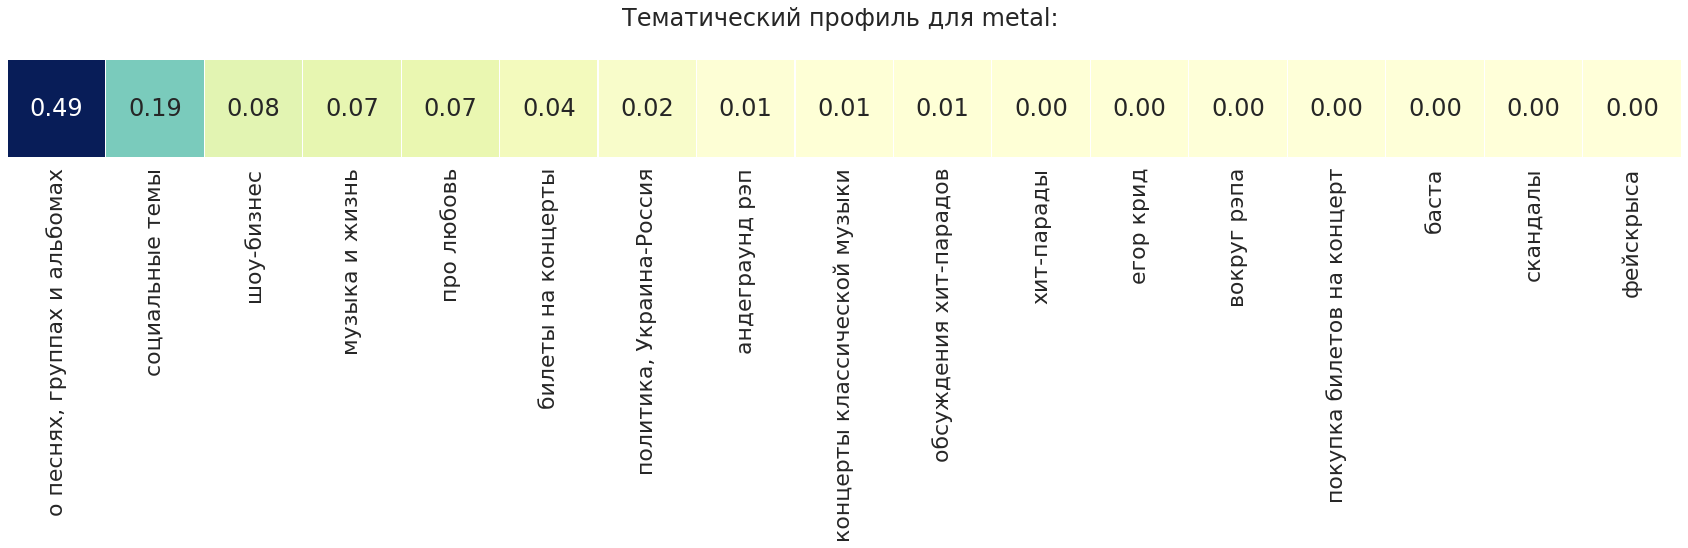

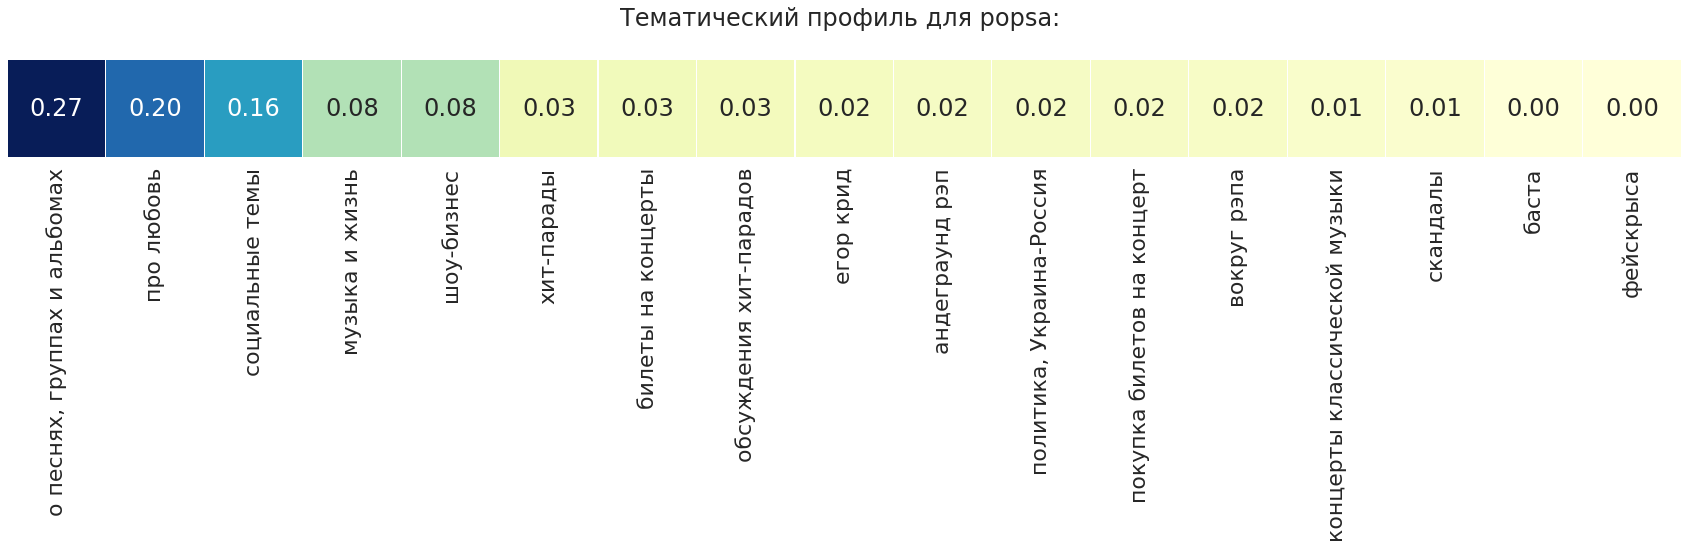

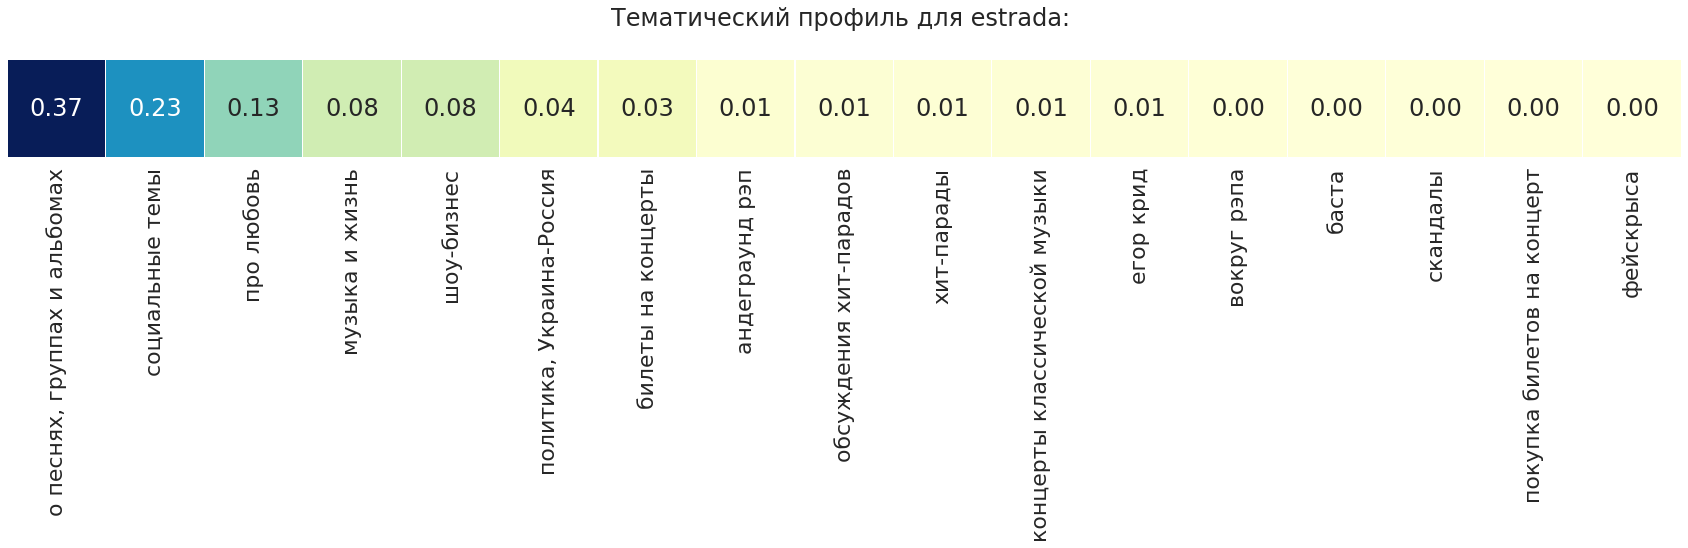

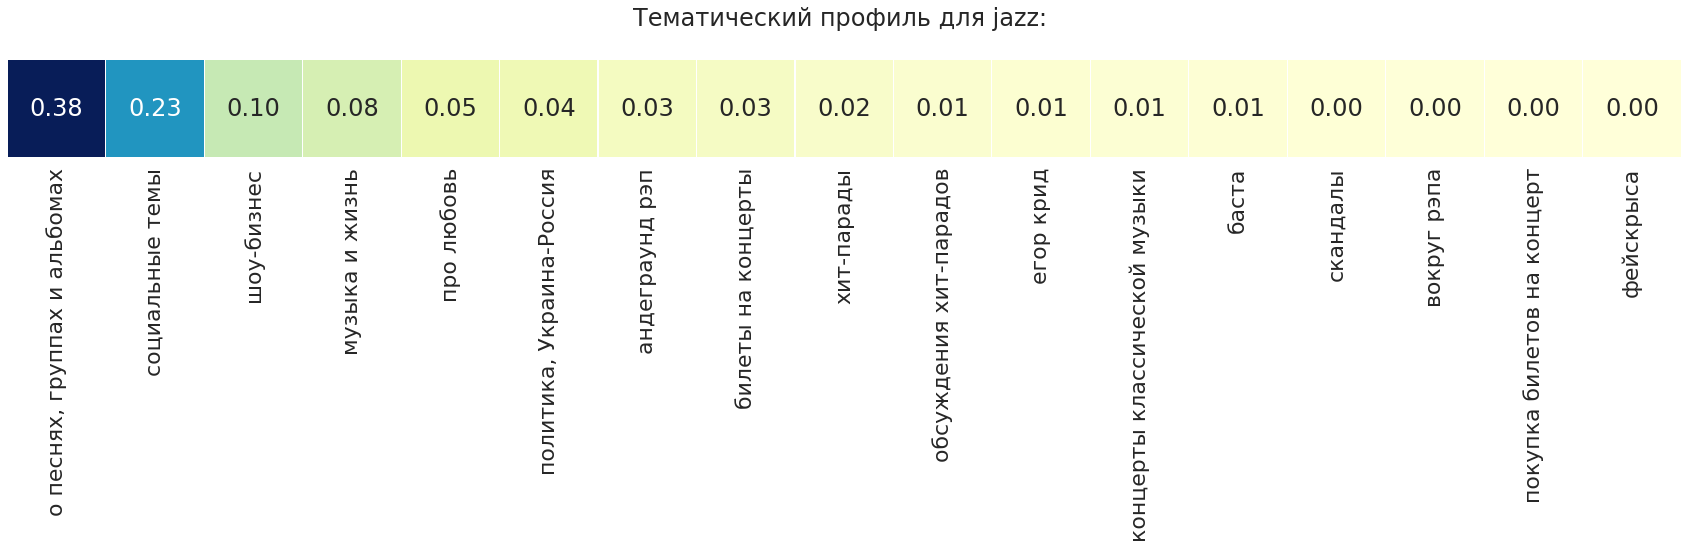

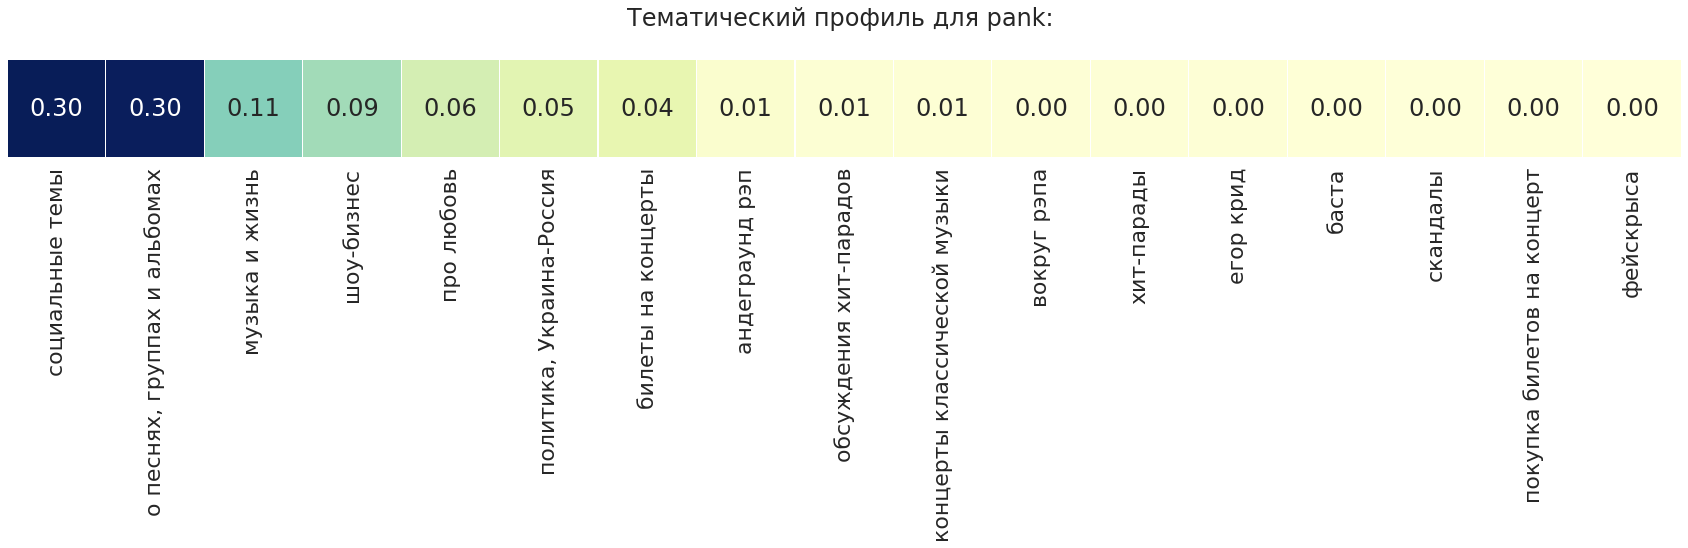

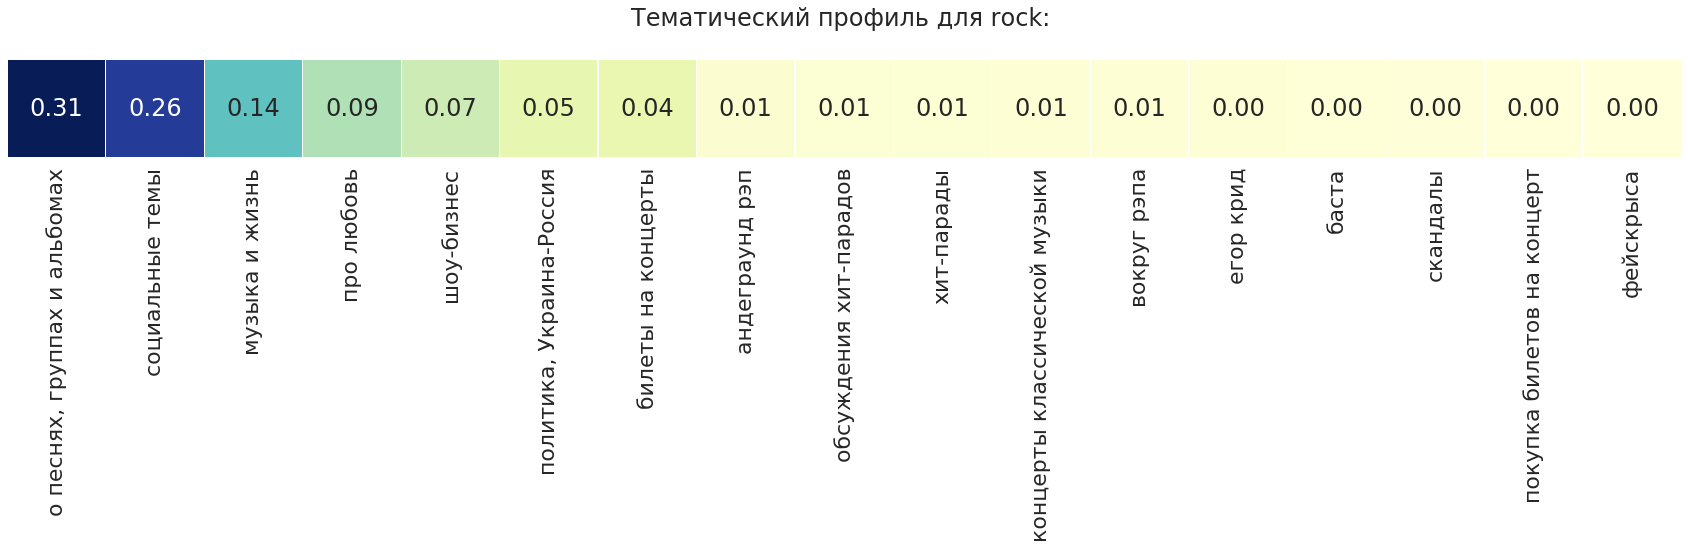

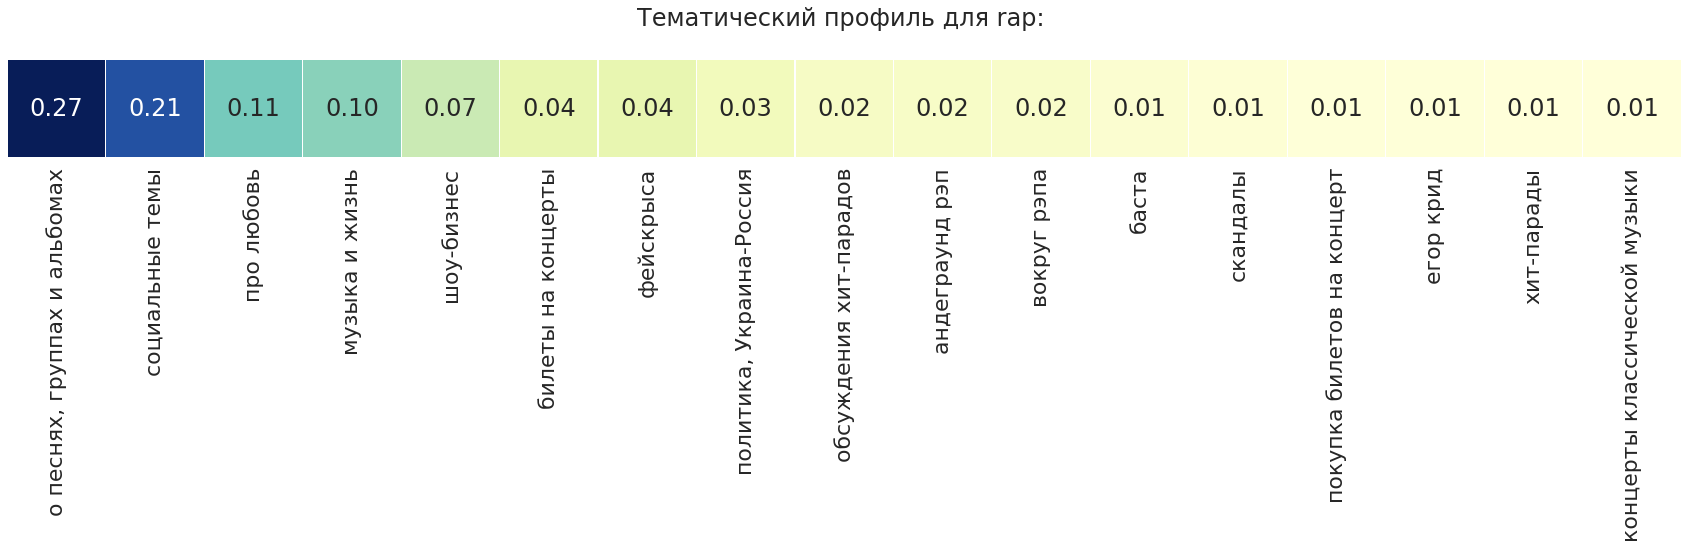

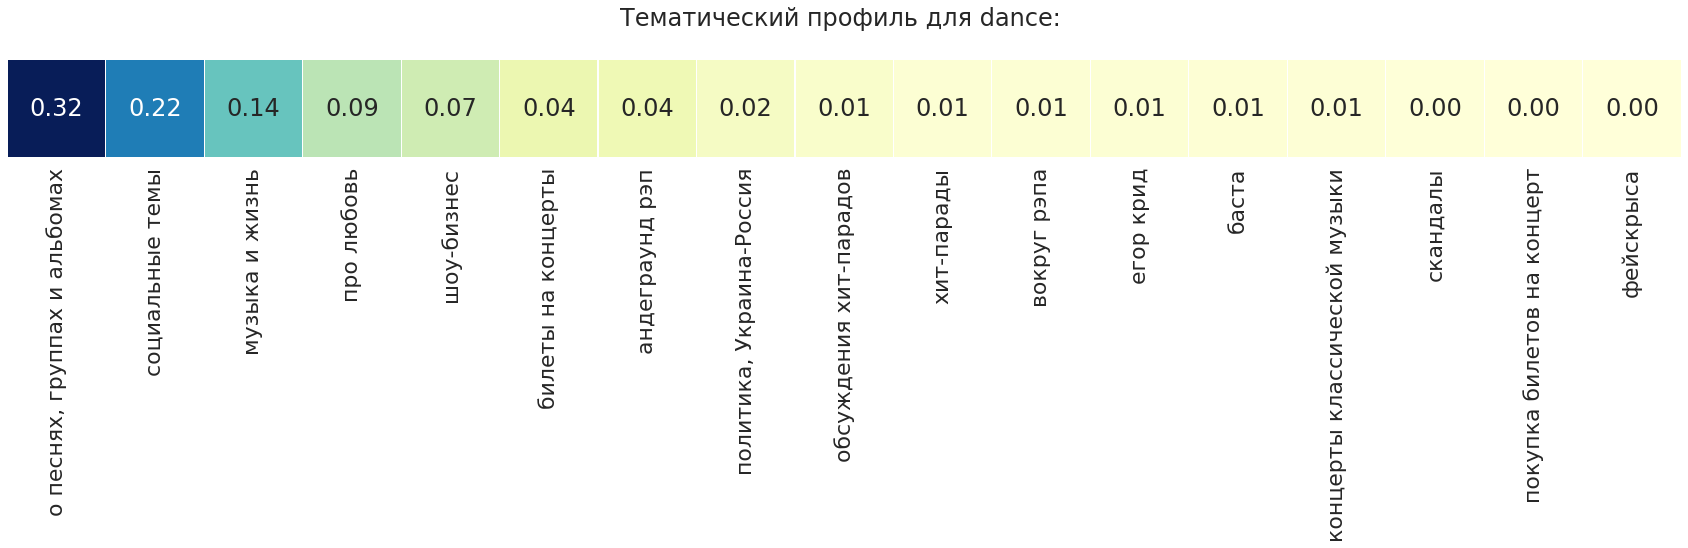

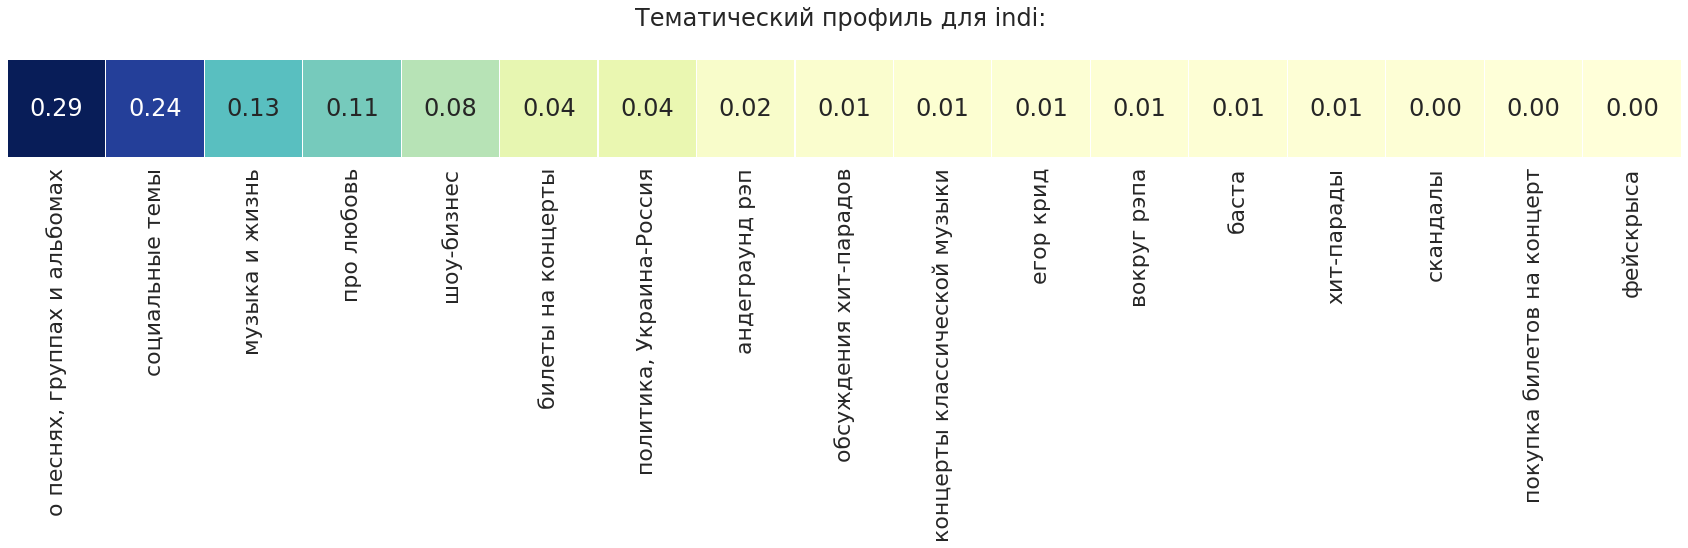

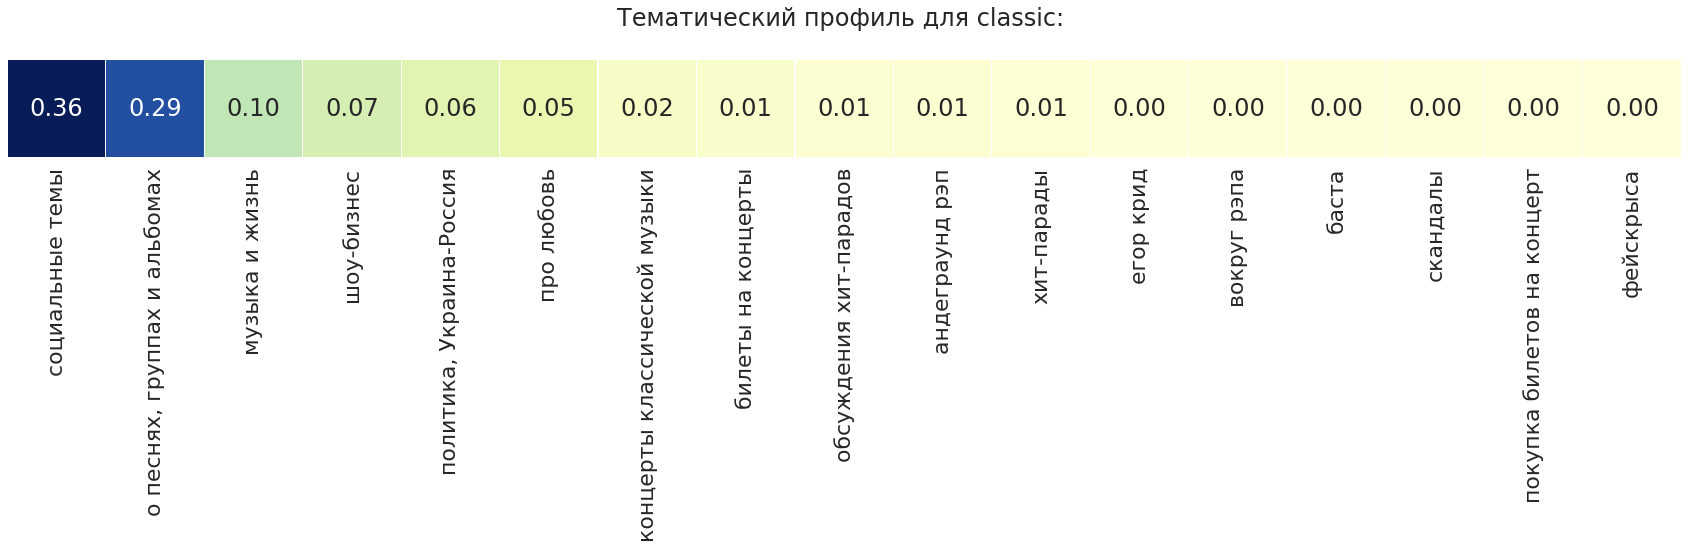

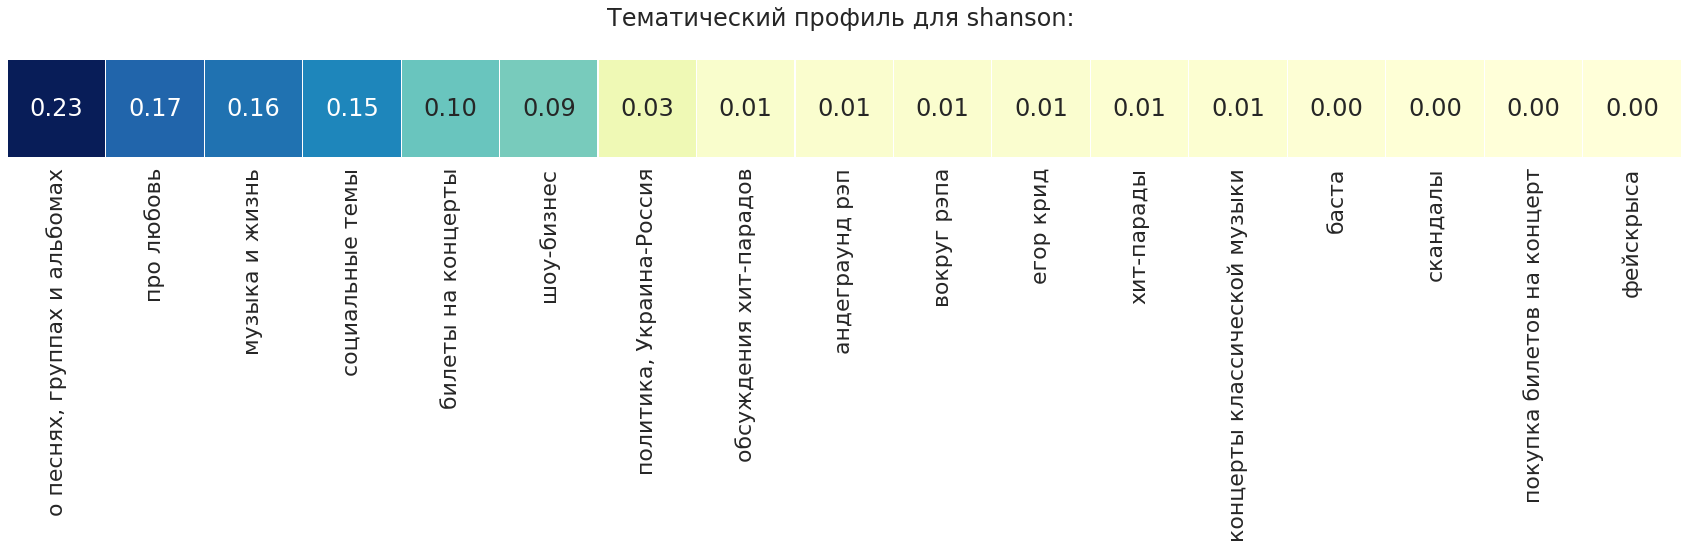

In [33]:
for music_style in music_styles:
    profilePlot(music_style_themes_clean, music_style, themes_25)

### Строим матрицу расстояний между жанрами

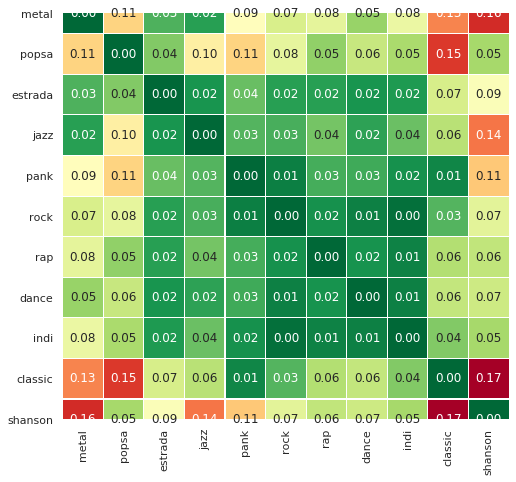

In [36]:
from scipy.spatial.distance import cosine
music_style = list(music_style_themes_clean.keys())
n = len(music_style)  # выясняем число жанров
R = np.zeros((n,n))  # заводим матрицу расстояний 

for i in range(n):
    can_1 = [item[1] for item in music_style_themes_clean[music_style[i]]]     # выделяем вектор для первого 
    for j in range(n):
        can_2 = [item[1] for item in music_style_themes_clean[music_style[j]]] # выделяем второй вектор 
        R[i,j] = cosine(can_1, can_2) # ищем косинусное расстояние
            
sns.set(font_scale=1)
plt.subplots(figsize=(8, 8))
sns.heatmap(R, square=True,
            annot=True, fmt=".2f", linewidths=0.1, cmap="RdYlGn_r",
            yticklabels=music_style, xticklabels=music_style,cbar=False);

## Визуализация тематических профилей при помощи TSNE

In [46]:
music_style_themes_clusters = {}
for k, v in music_style_themes_clean.items():
    music_style_themes_clusters[k] = [prob[1] for prob in v]
    
df_music_style_themes_clusters = pd.DataFrame(music_style_themes_clusters).T

In [39]:
from MulticoreTSNE import MulticoreTSNE

In [52]:
tsne = MulticoreTSNE()
tsne_features = tsne.fit_transform(df_music_style_themes_clusters)

In [53]:
tsne_features

array([[ 90.62975623,  20.11391824],
       [ -1.90995   ,  62.71524773],
       [ 41.89738392,  14.10221666],
       [ 62.53022902,   8.10095615],
       [-57.99695191, -39.16582063],
       [-34.44166933, -23.75424502],
       [ 13.62303215, -35.16158334],
       [ -6.34313378,  -2.04215376],
       [-12.99997031, -28.78974606],
       [-75.72200367, -57.78338744],
       [-19.26672232,  81.66459747]])

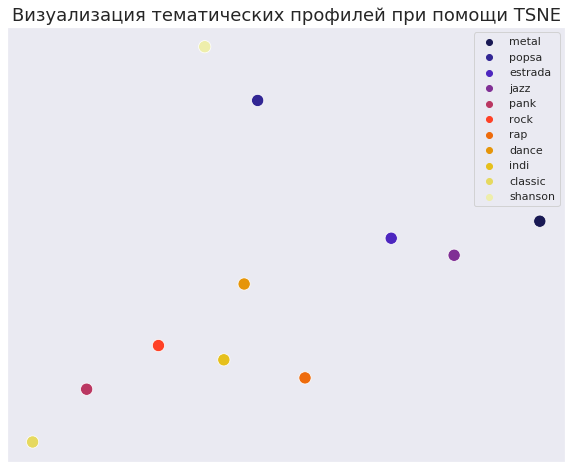

In [74]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.scatterplot(
    x=tsne_features[:, 0], 
    y=tsne_features[:, 1], 
    hue=df_music_style_themes_clusters.index, 
    palette="CMRmap",
    s=150
)
plt.title("Визуализация тематических профилей при помощи TSNE", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])
plt.show()